Analyzing sa data for single glasses.
230 dispensed glasses loaded.
27 unsuccessful searches loaded.


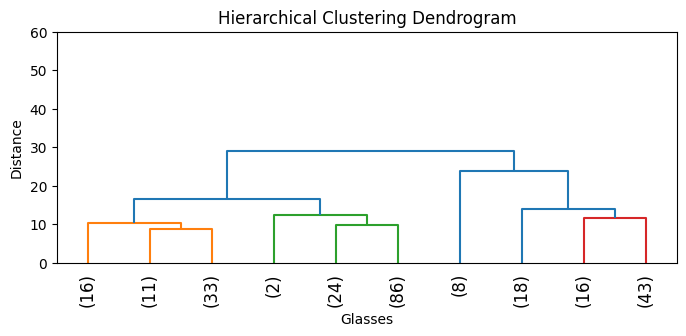

cluster
1     59
2    112
3      8
4     77
dtype: int64


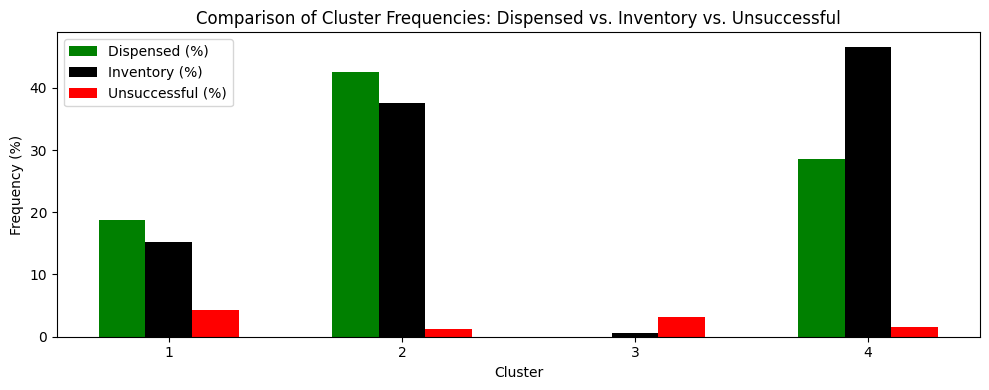

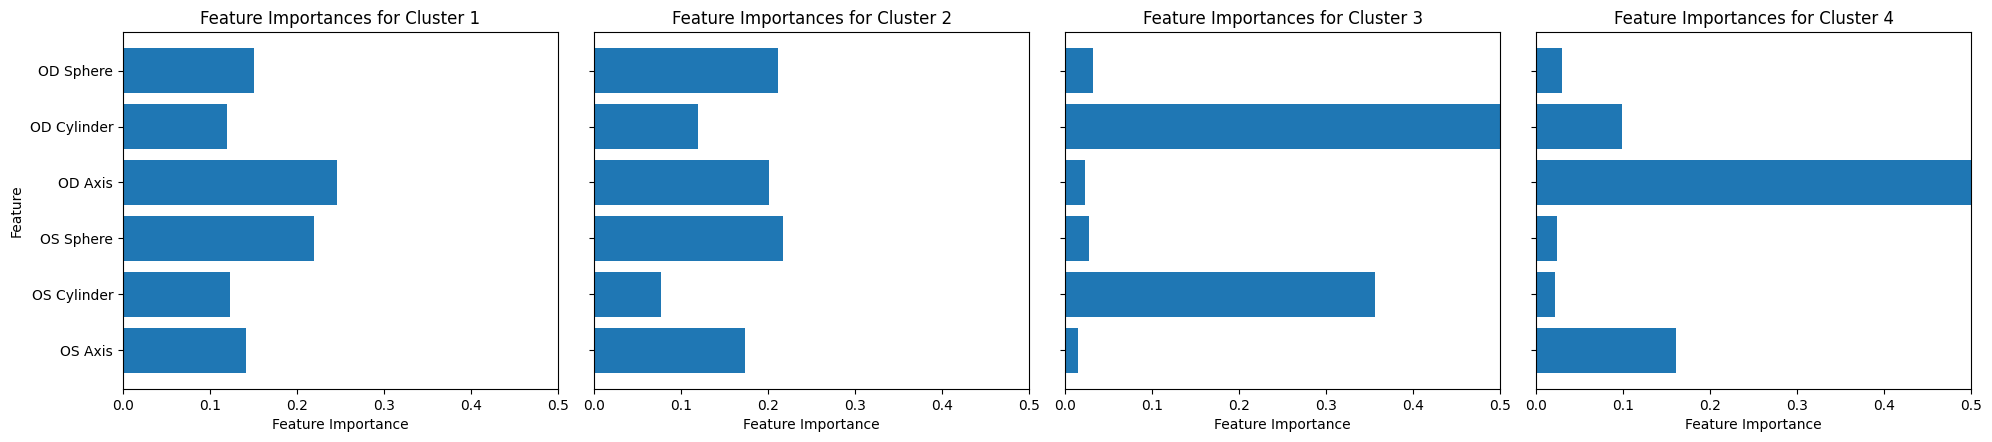

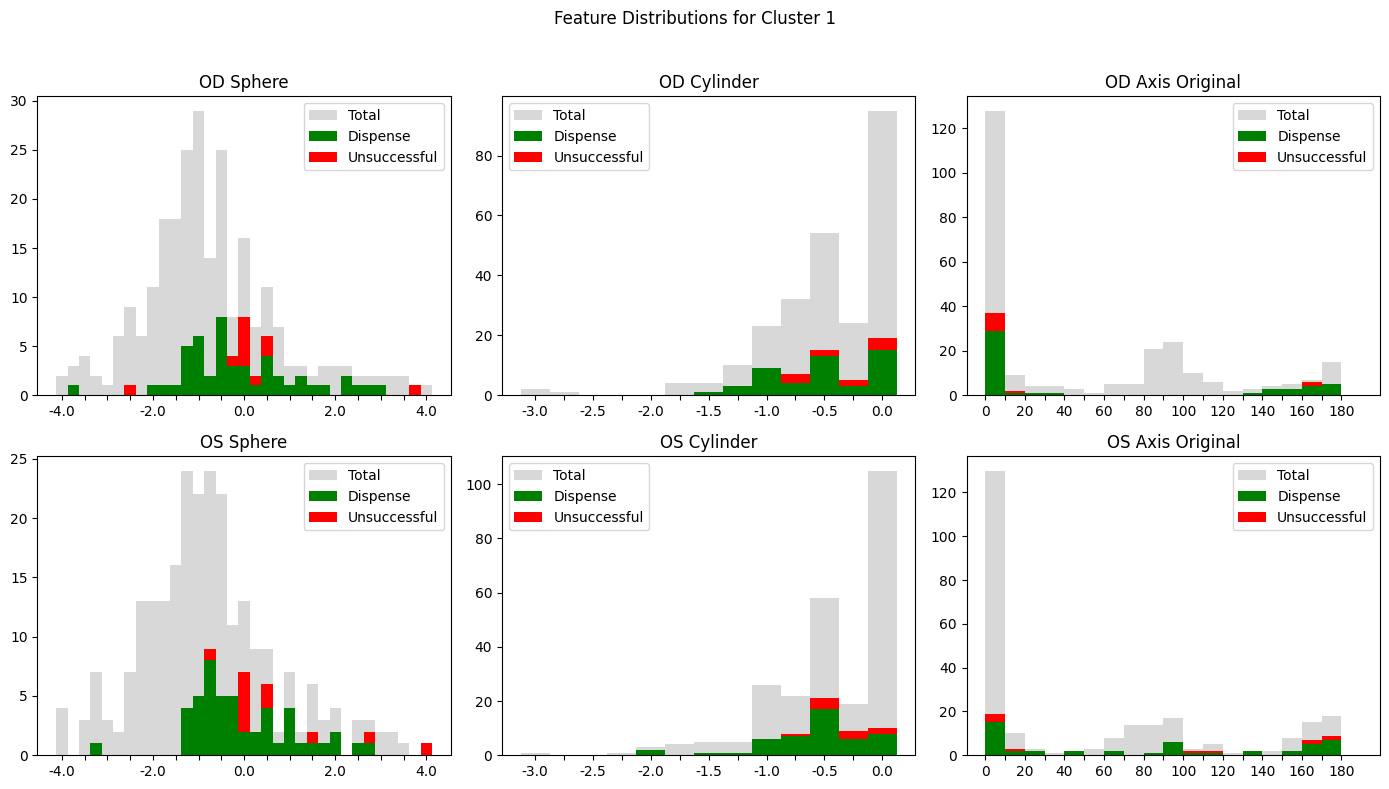

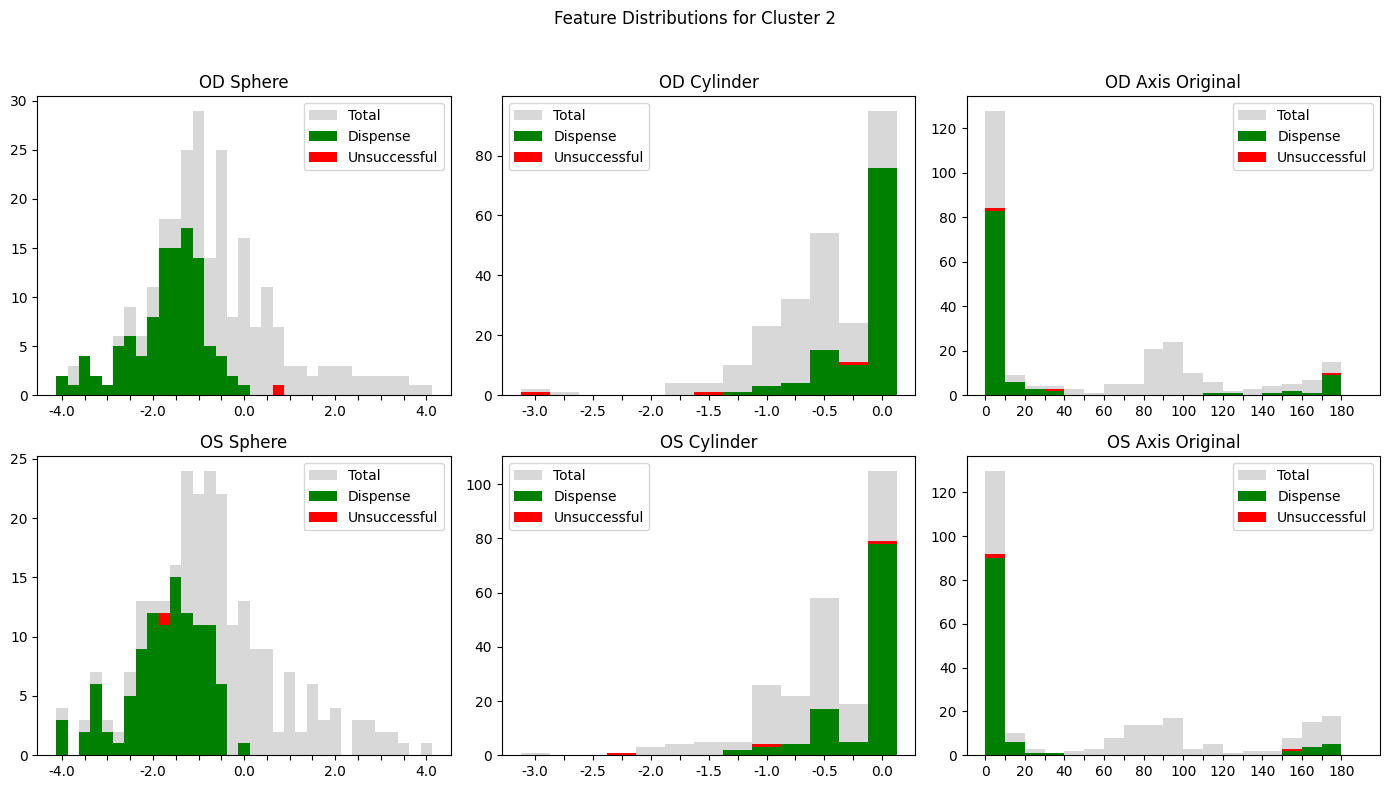

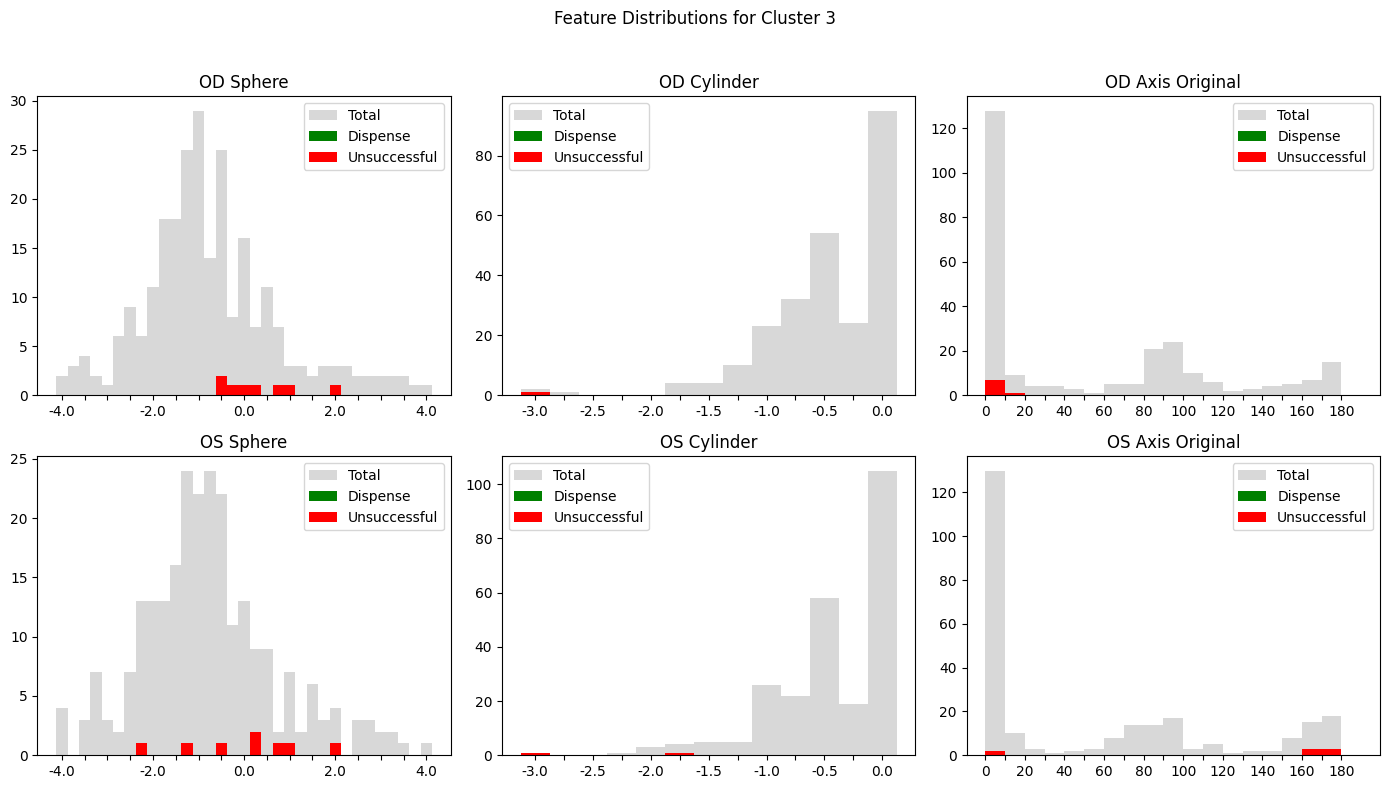

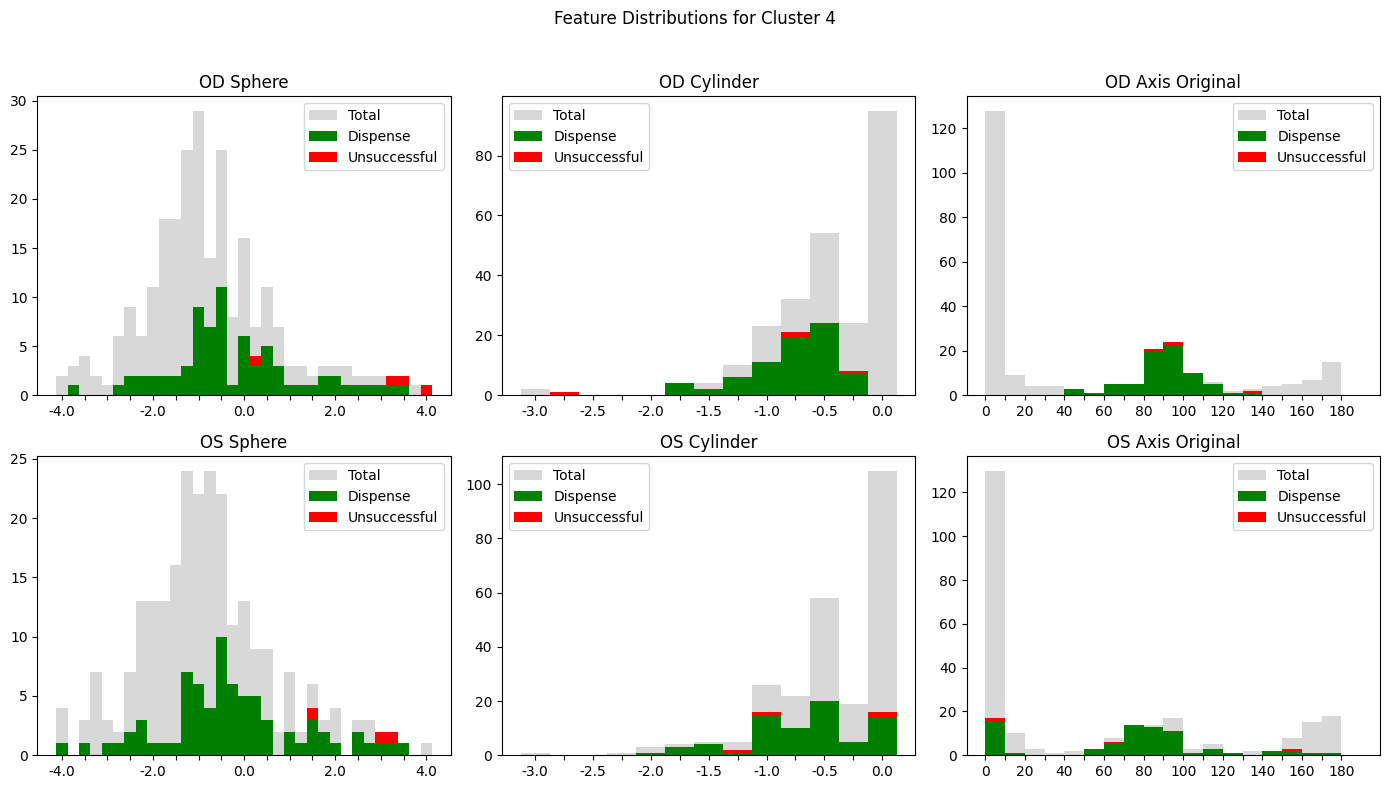

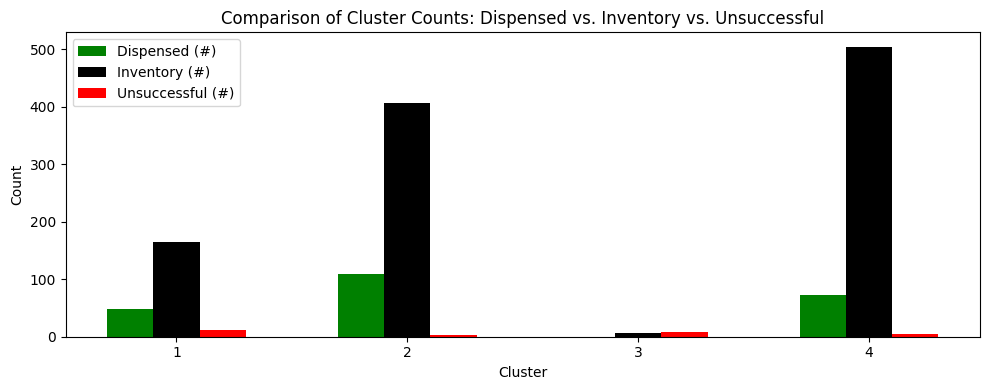

In [1]:
from analysis import launch
launch(multifocal=False, location='sa', cluster_count=4)

Analyzing sm data for single glasses.
193 dispensed glasses loaded.
56 unsuccessful searches loaded.


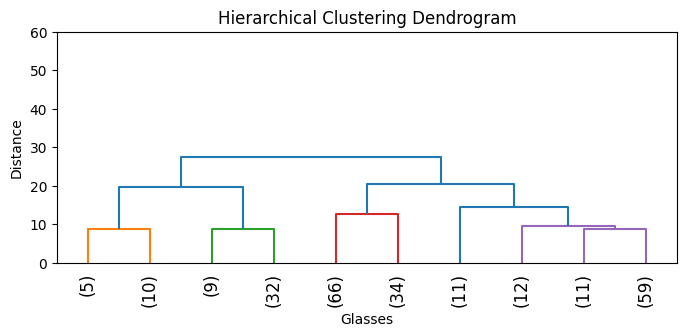

cluster
1    13
2    41
3    98
4    89
dtype: int64


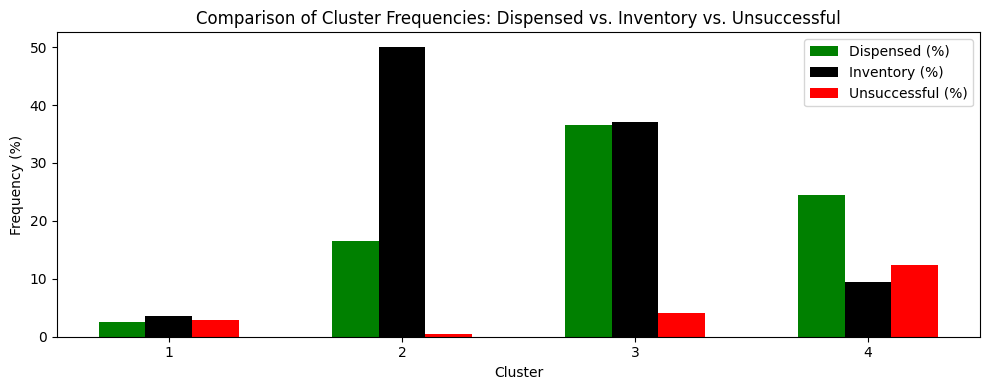

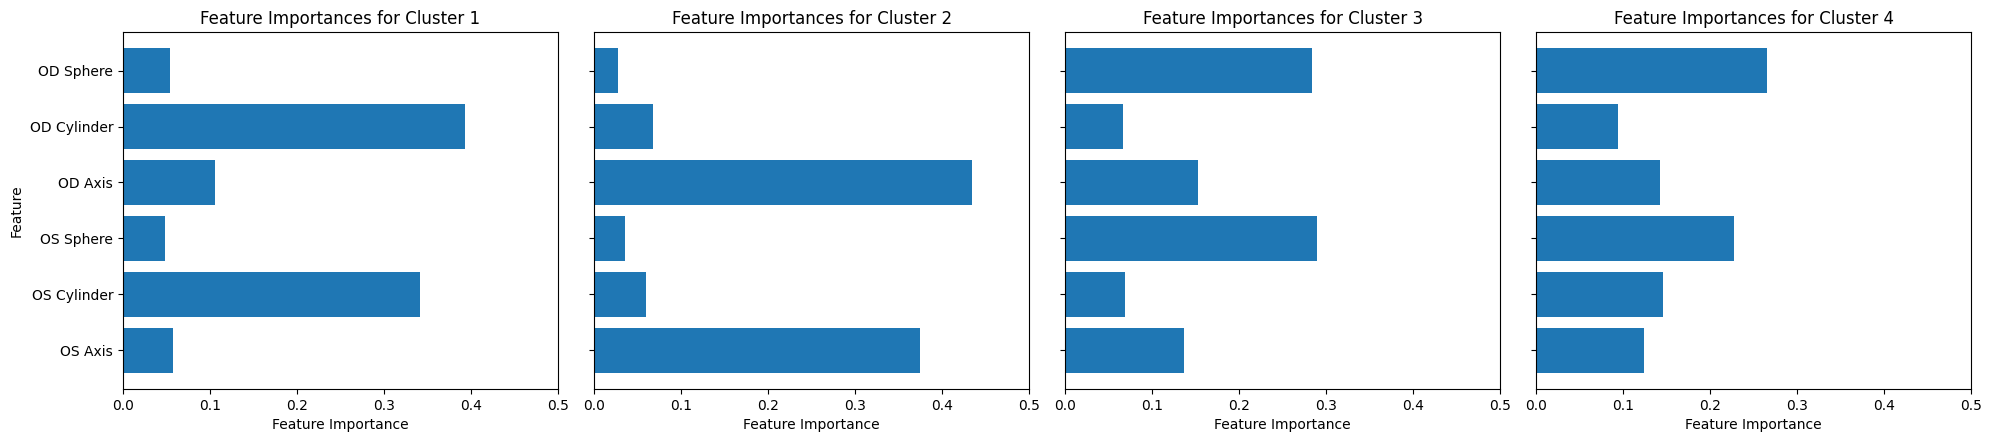

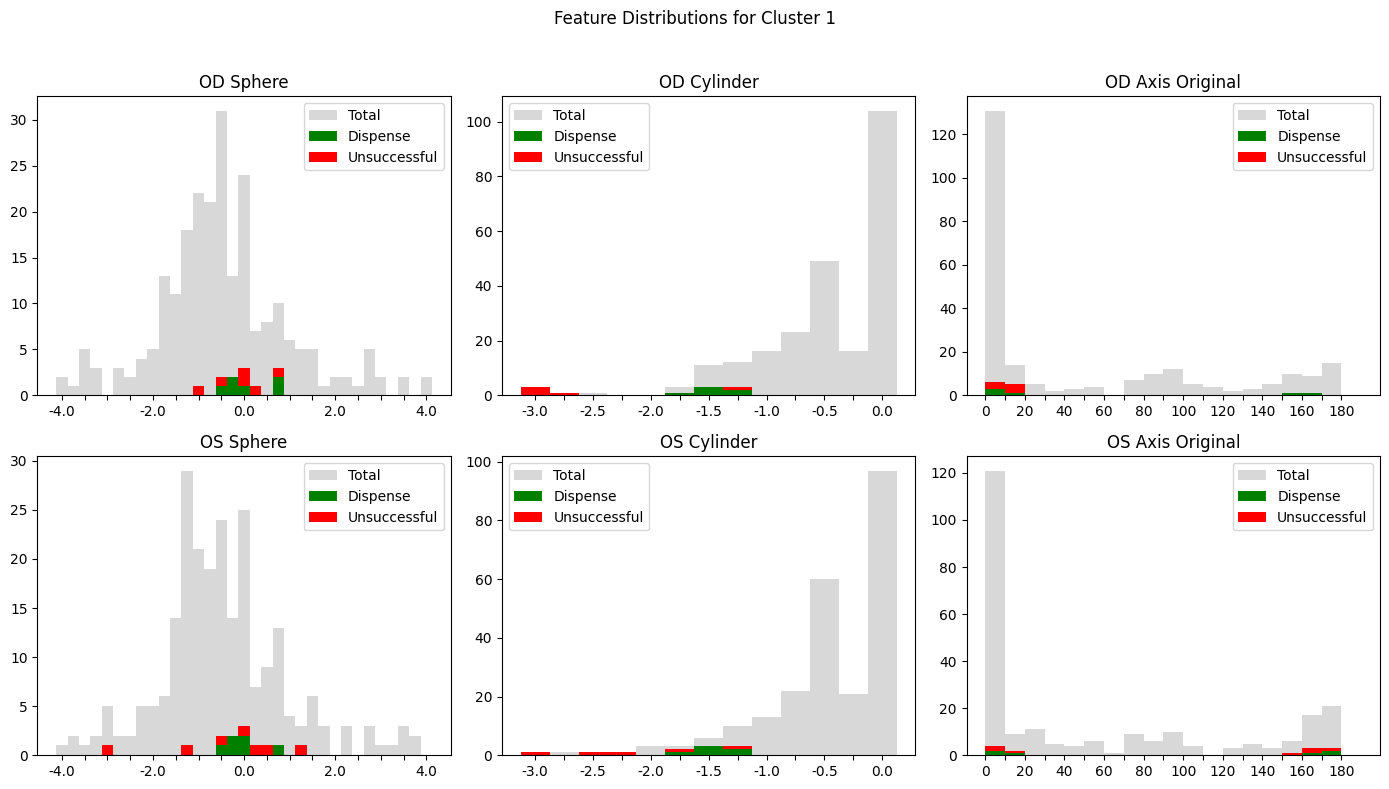

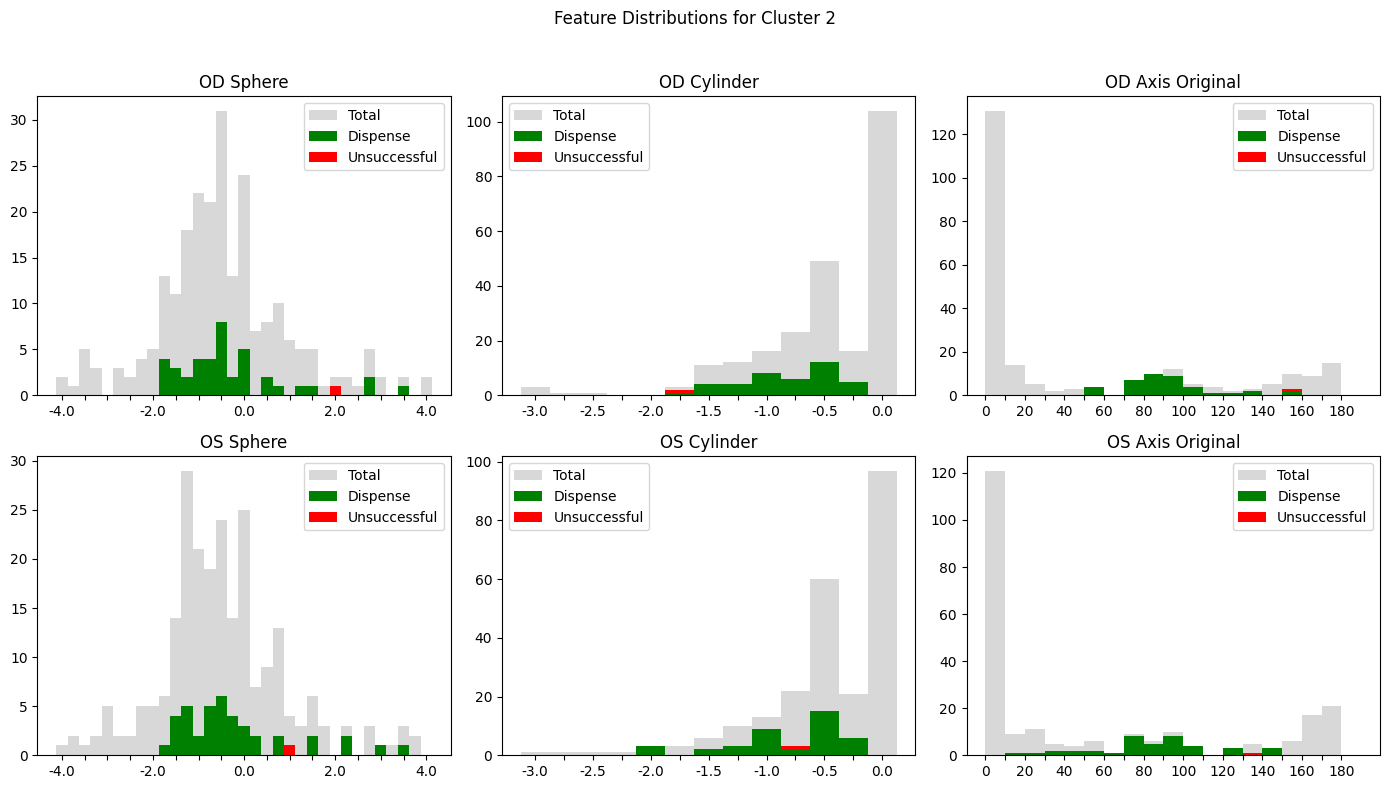

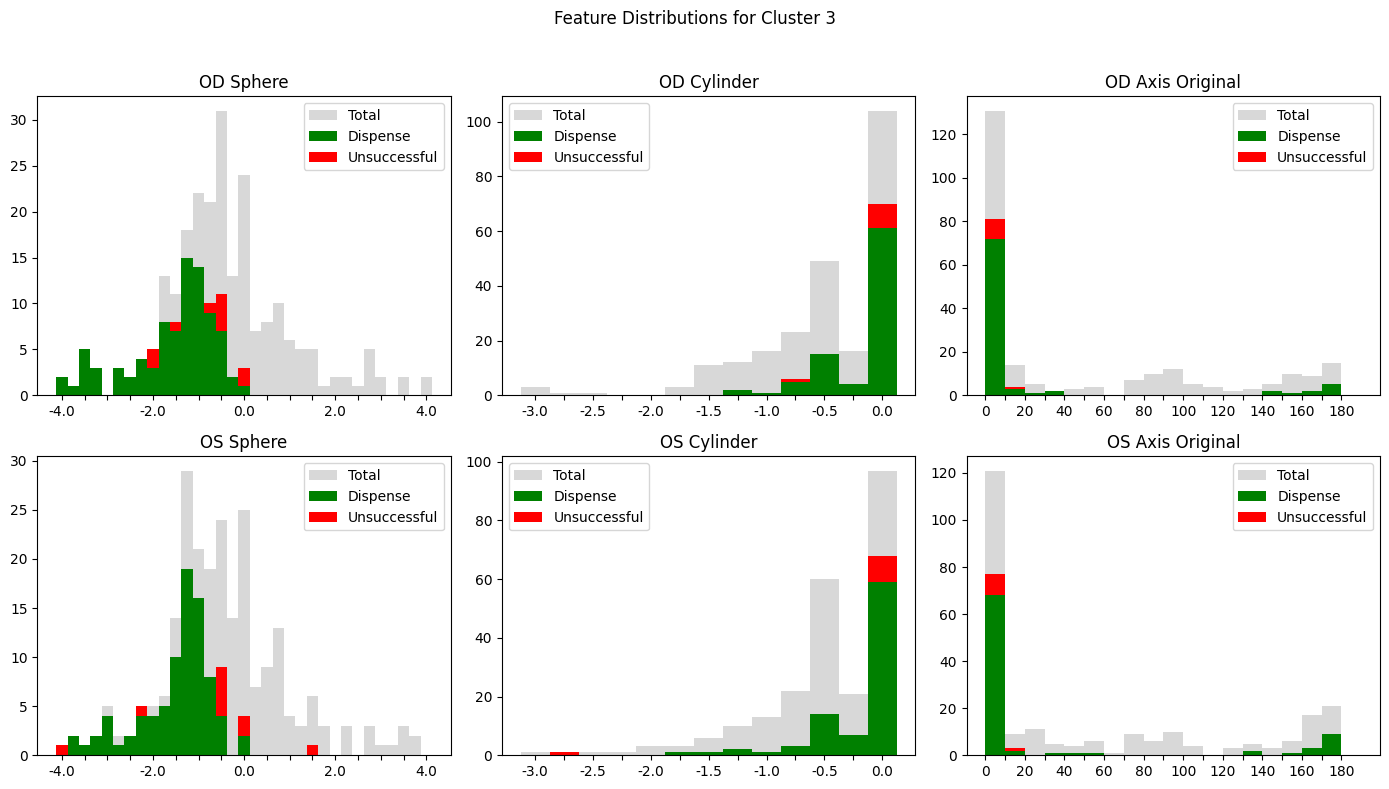

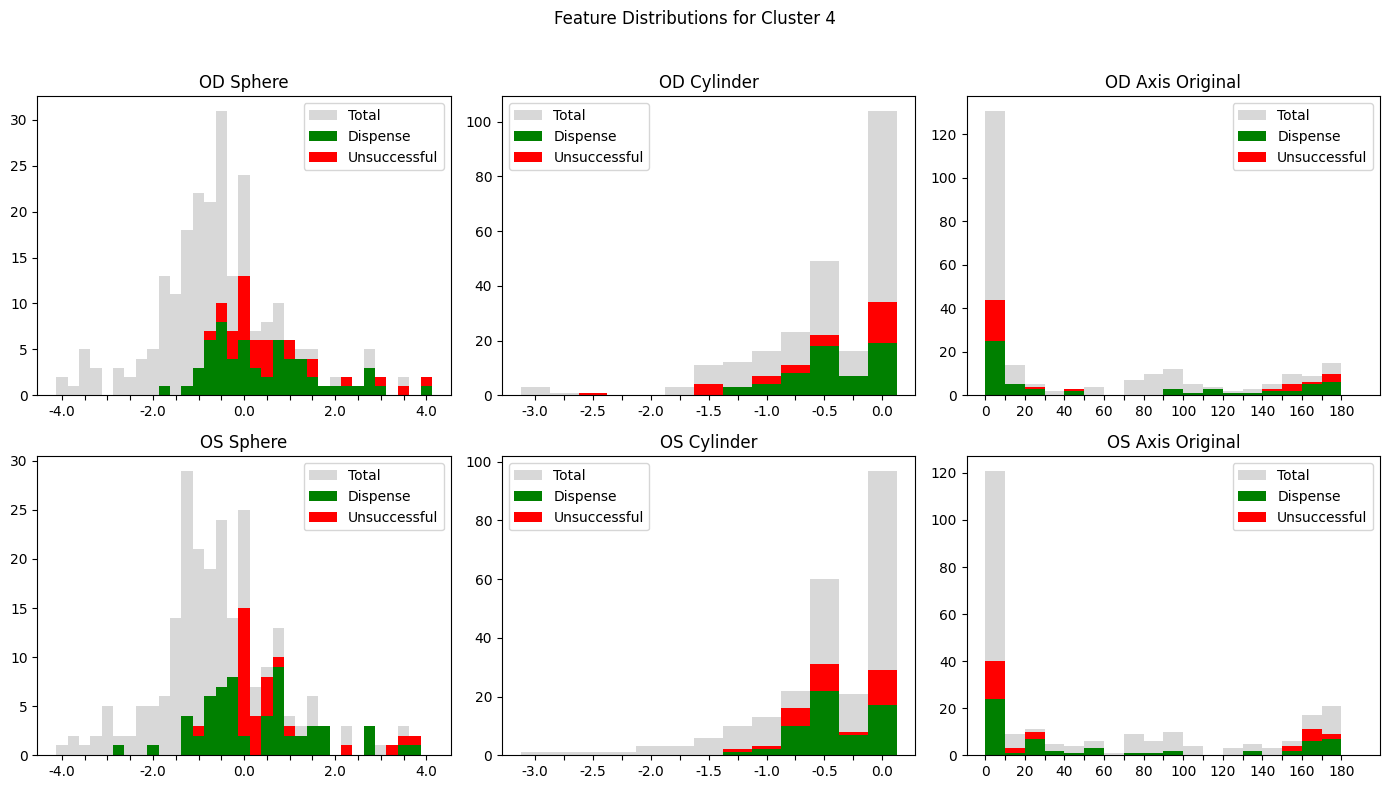

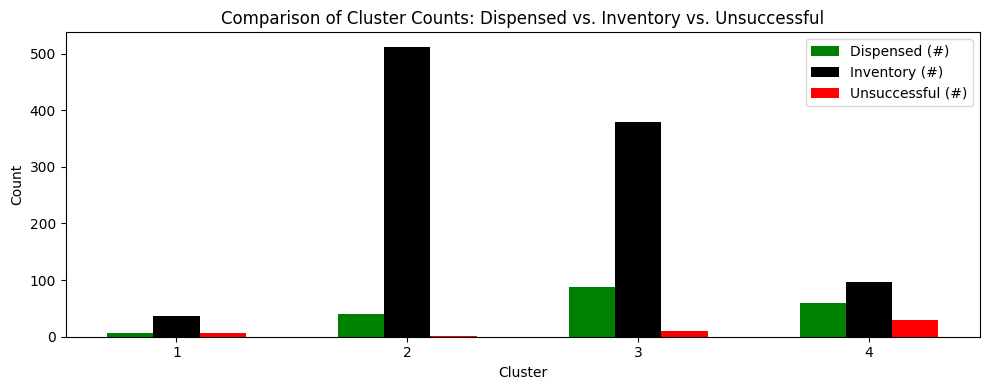

In [2]:
from analysis import launch
launch(multifocal=False, location='sm', cluster_count=4)

Analyzing sa data for multifocal glasses.
1023 dispensed glasses loaded.
70 unsuccessful searches loaded.


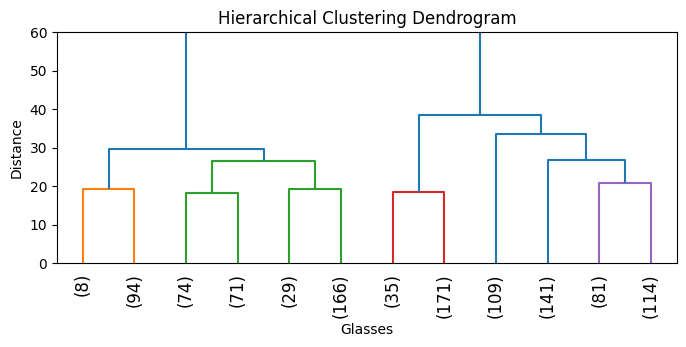

cluster
1    102
2    340
3    204
4    108
5    334
dtype: int64


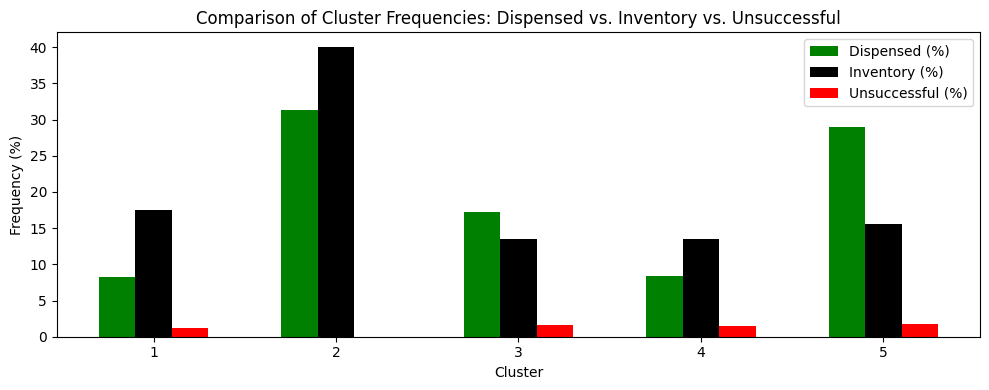

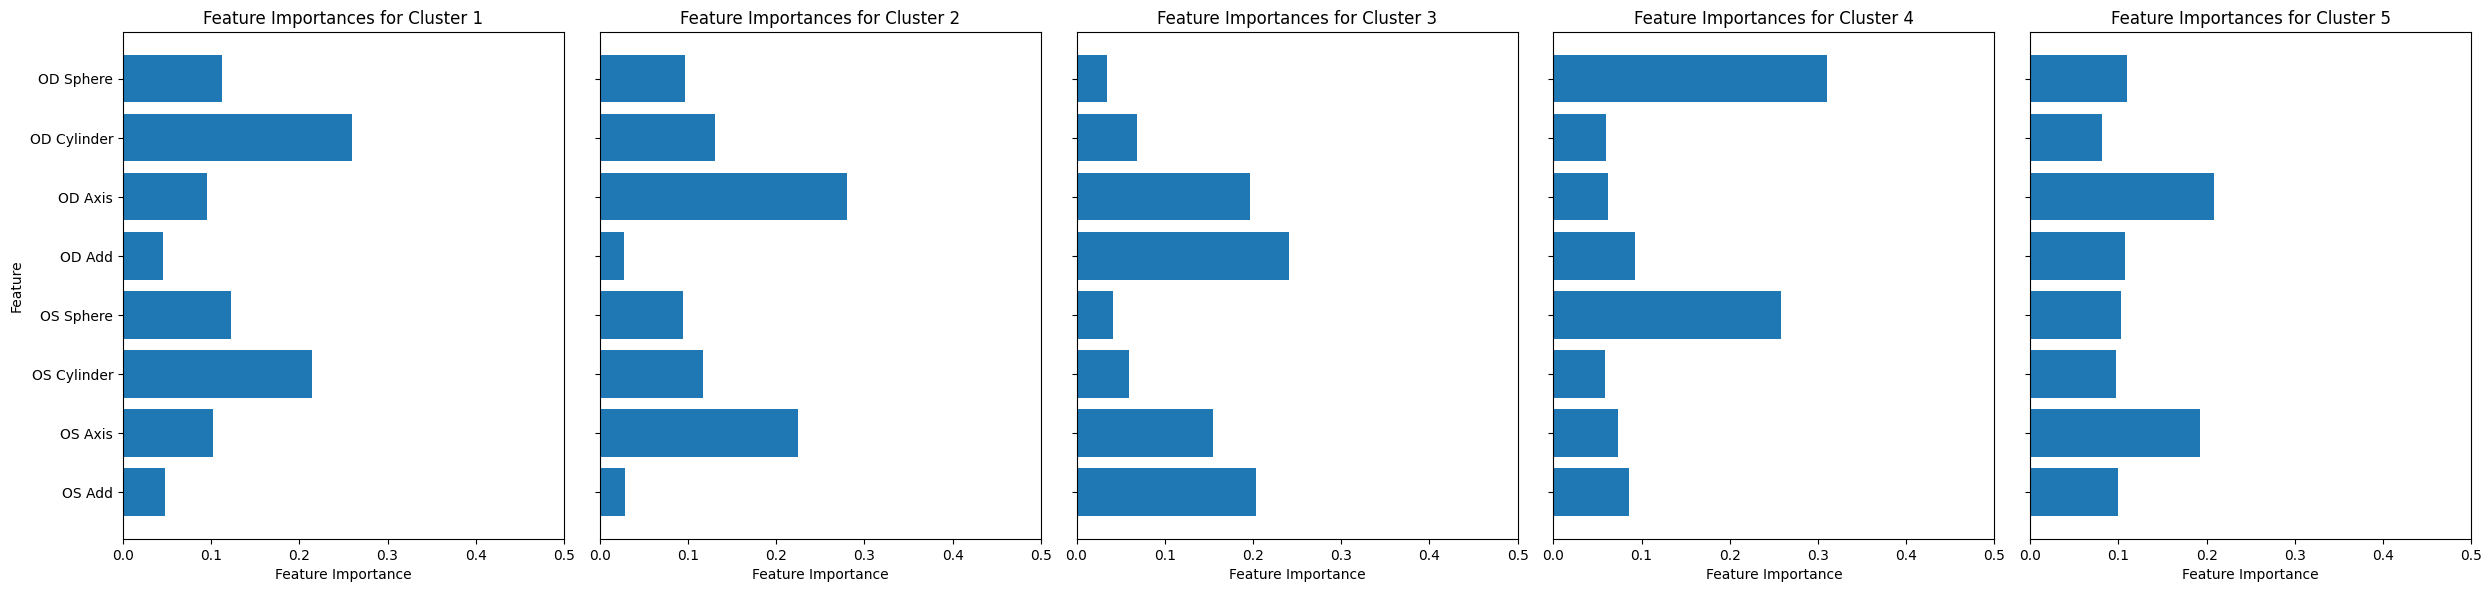

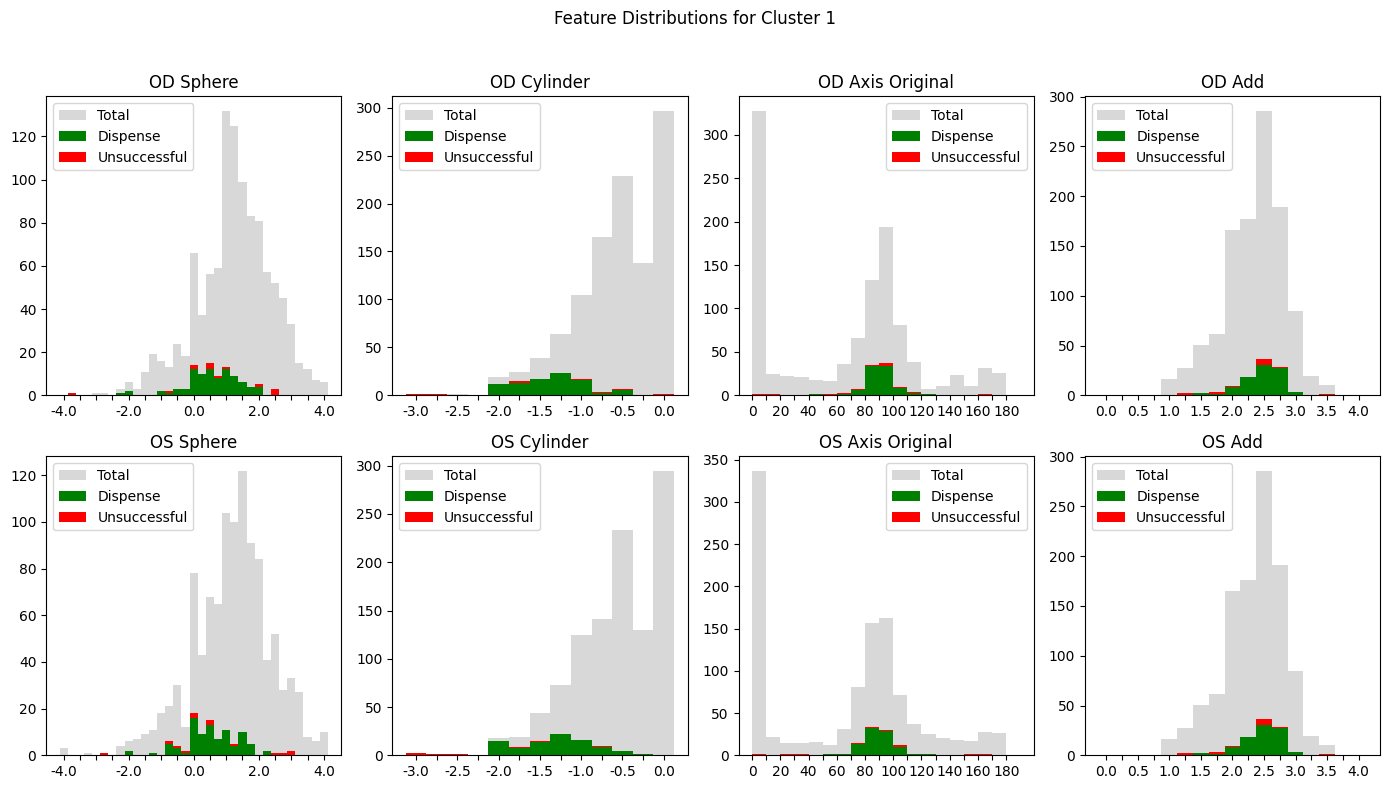

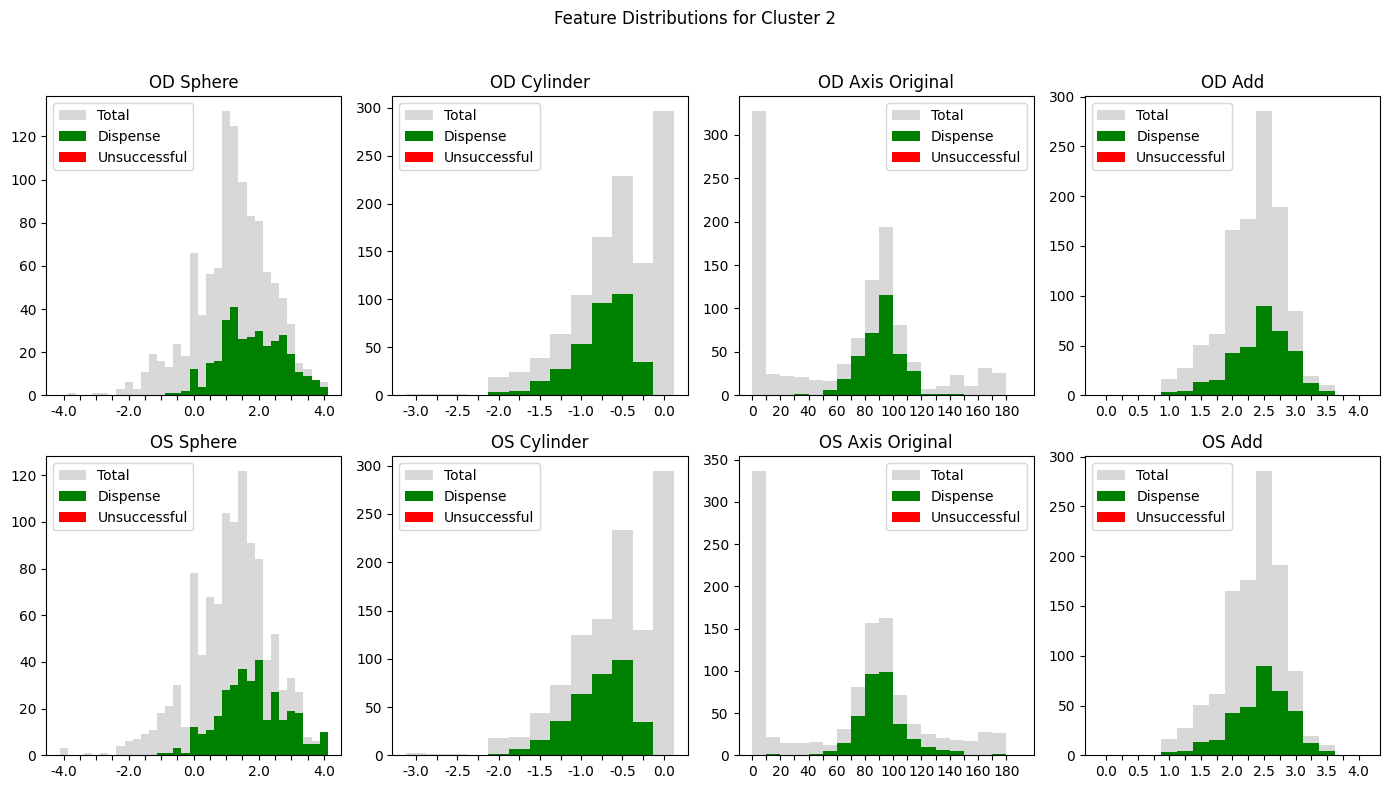

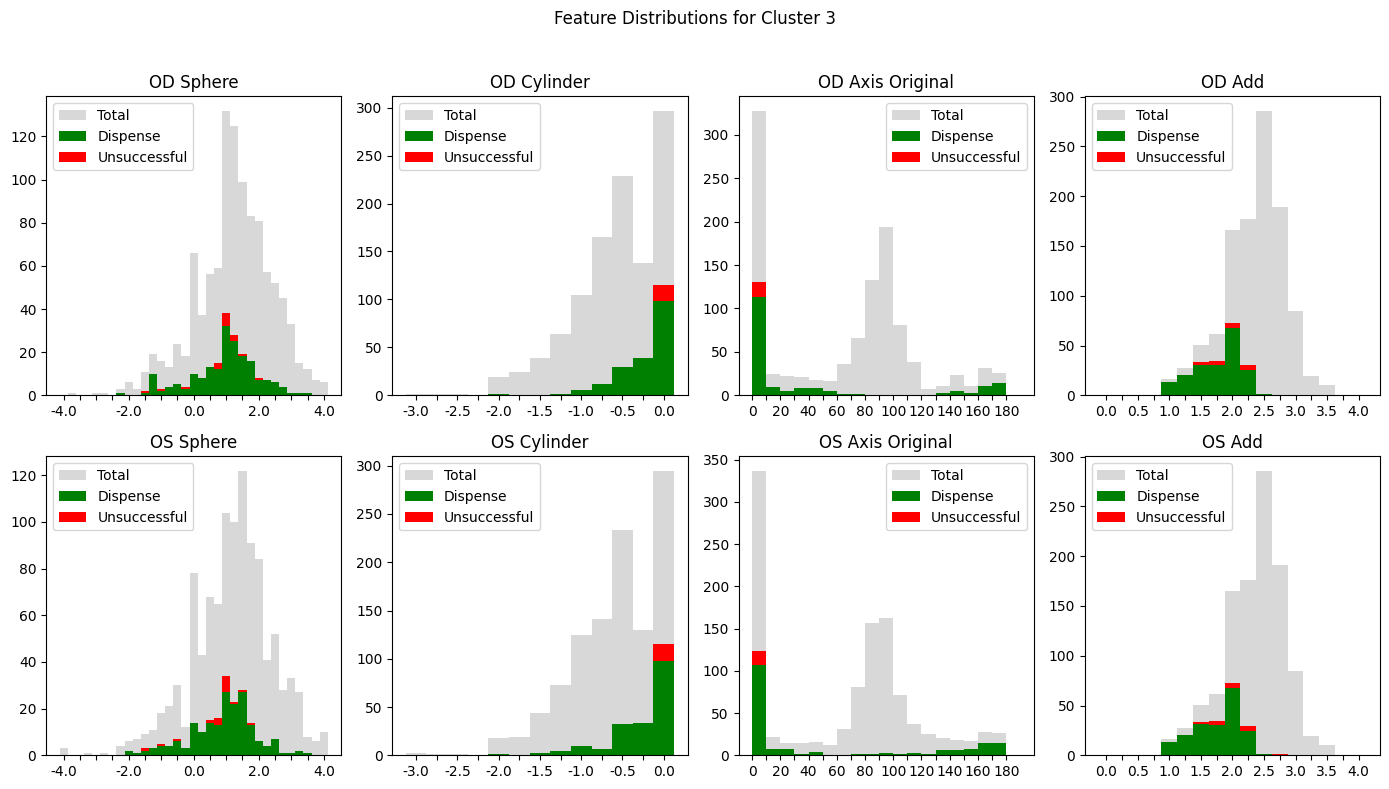

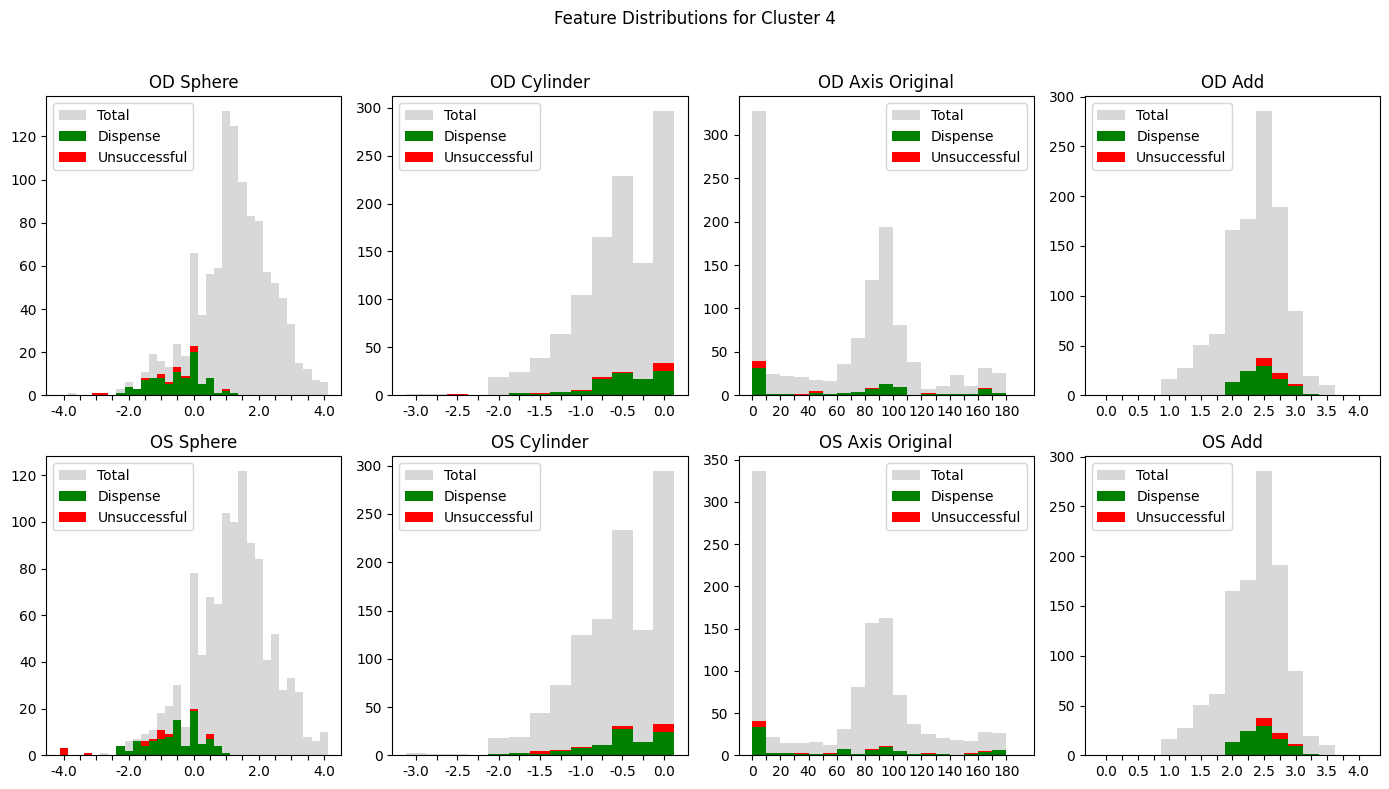

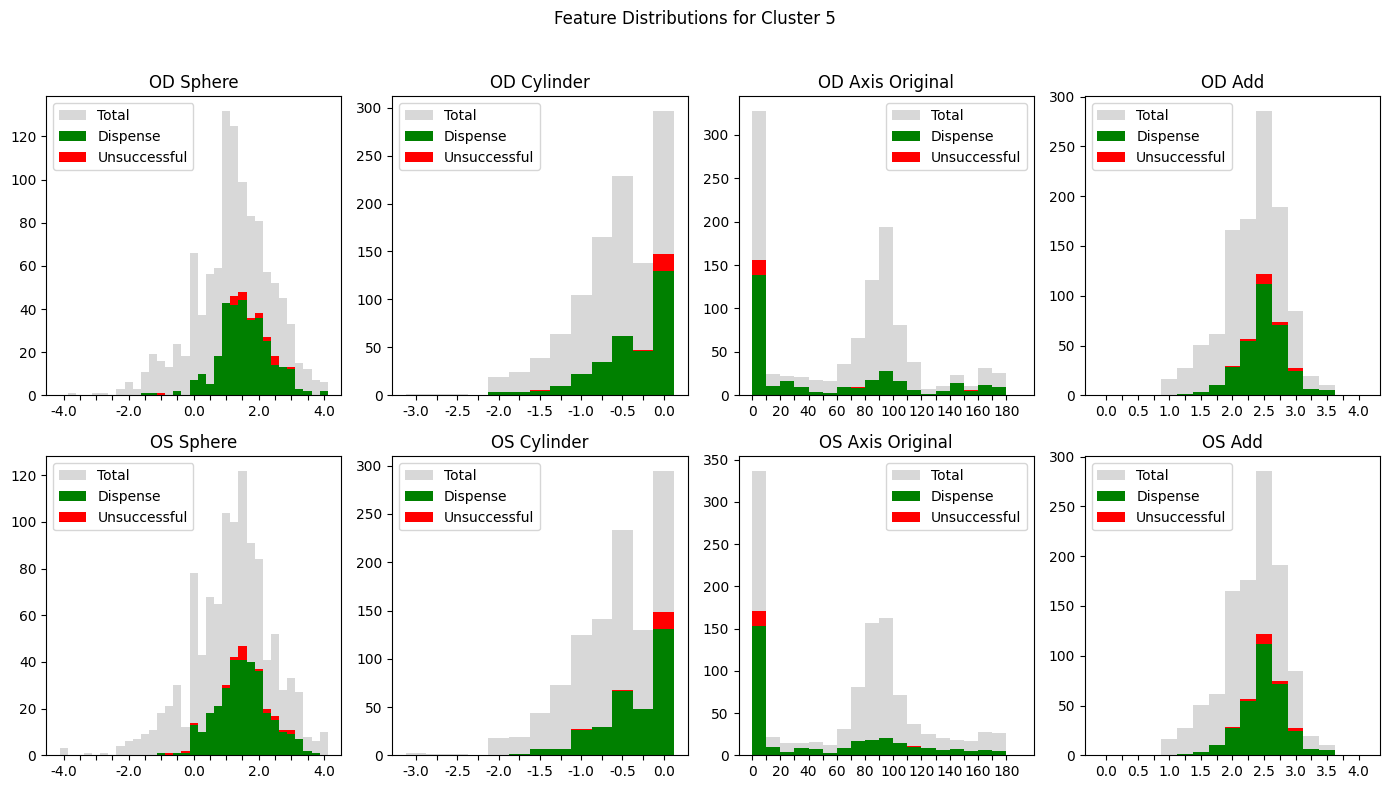

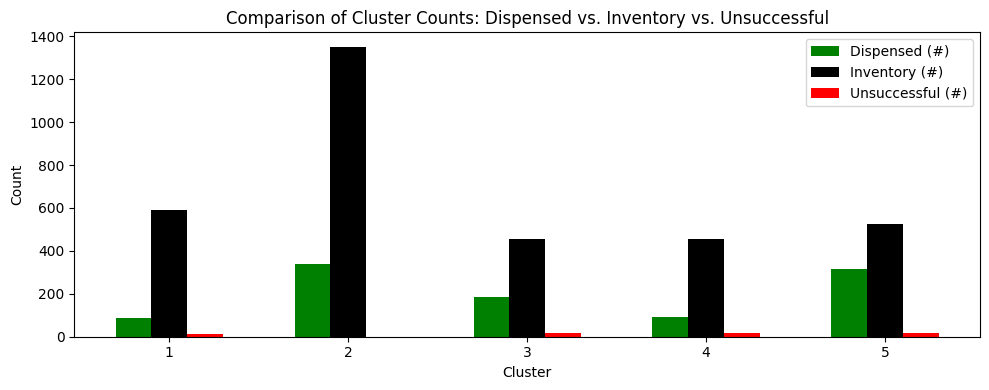

In [3]:
from analysis import launch
launch(multifocal=True, location='sa', cluster_count=5)

Analyzing sm data for multifocal glasses.
930 dispensed glasses loaded.
79 unsuccessful searches loaded.


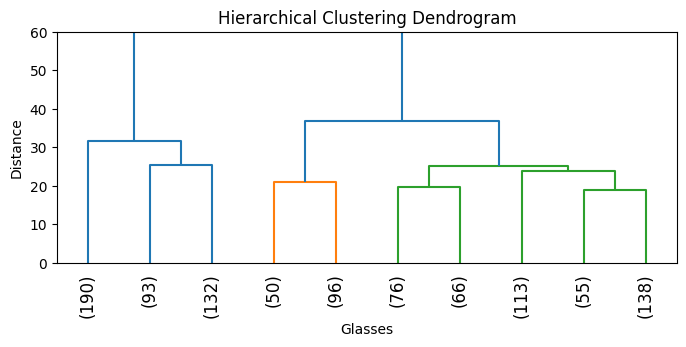

cluster
1    190
2    225
3    142
4    441
dtype: int64


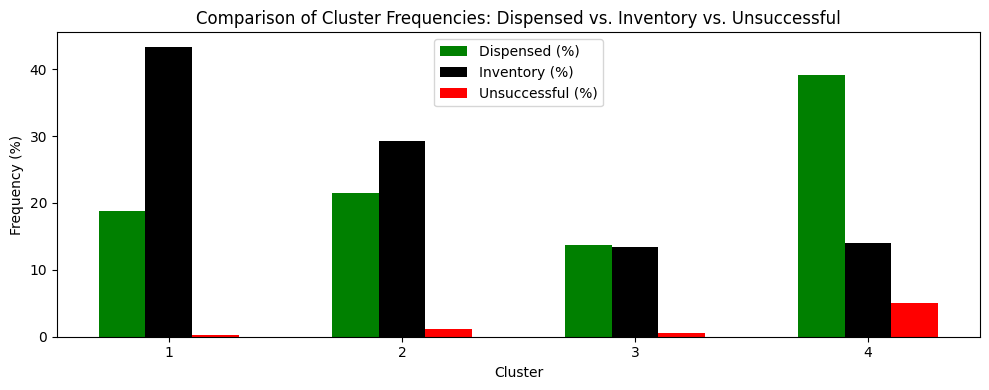

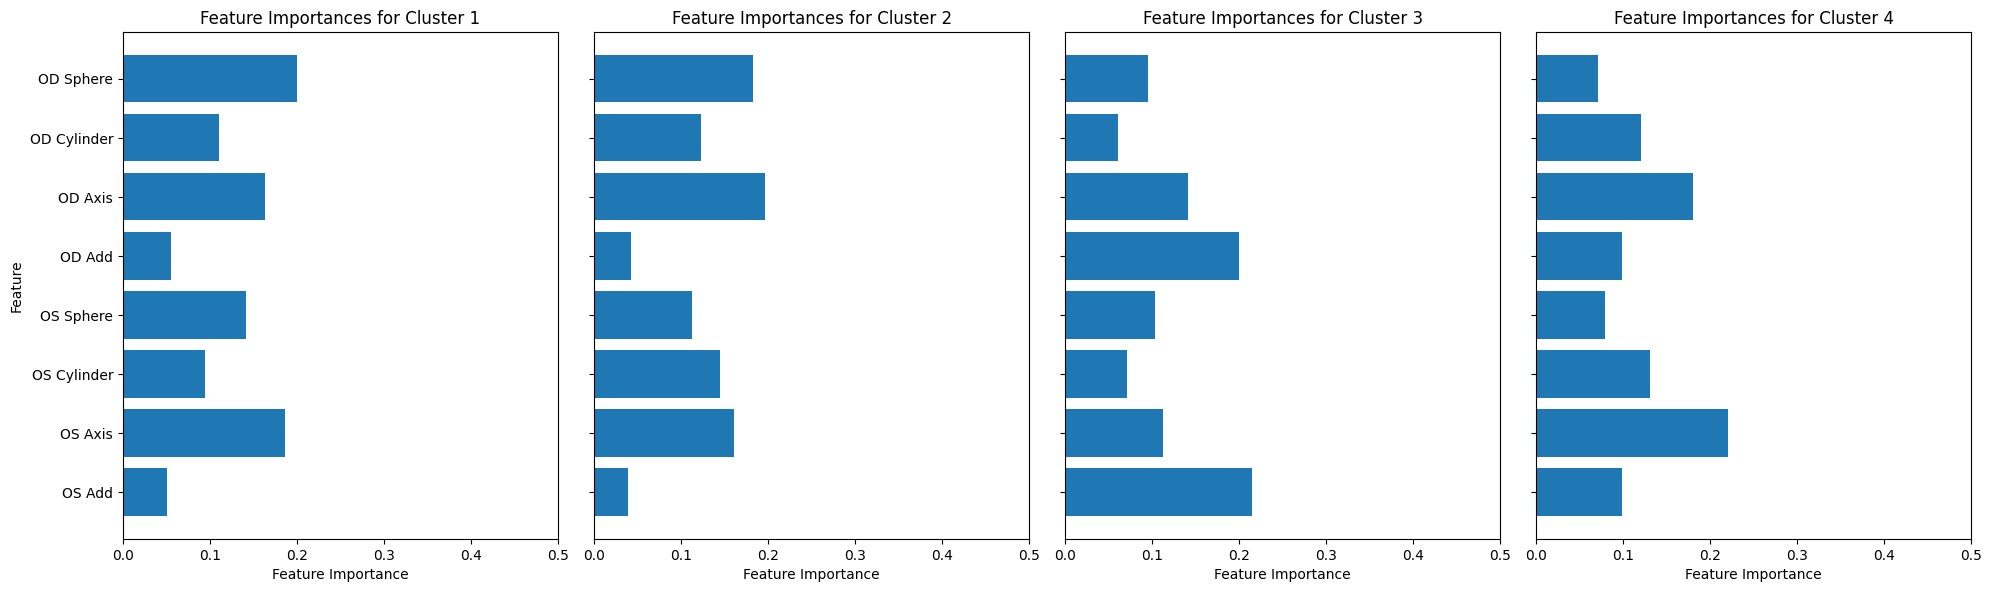

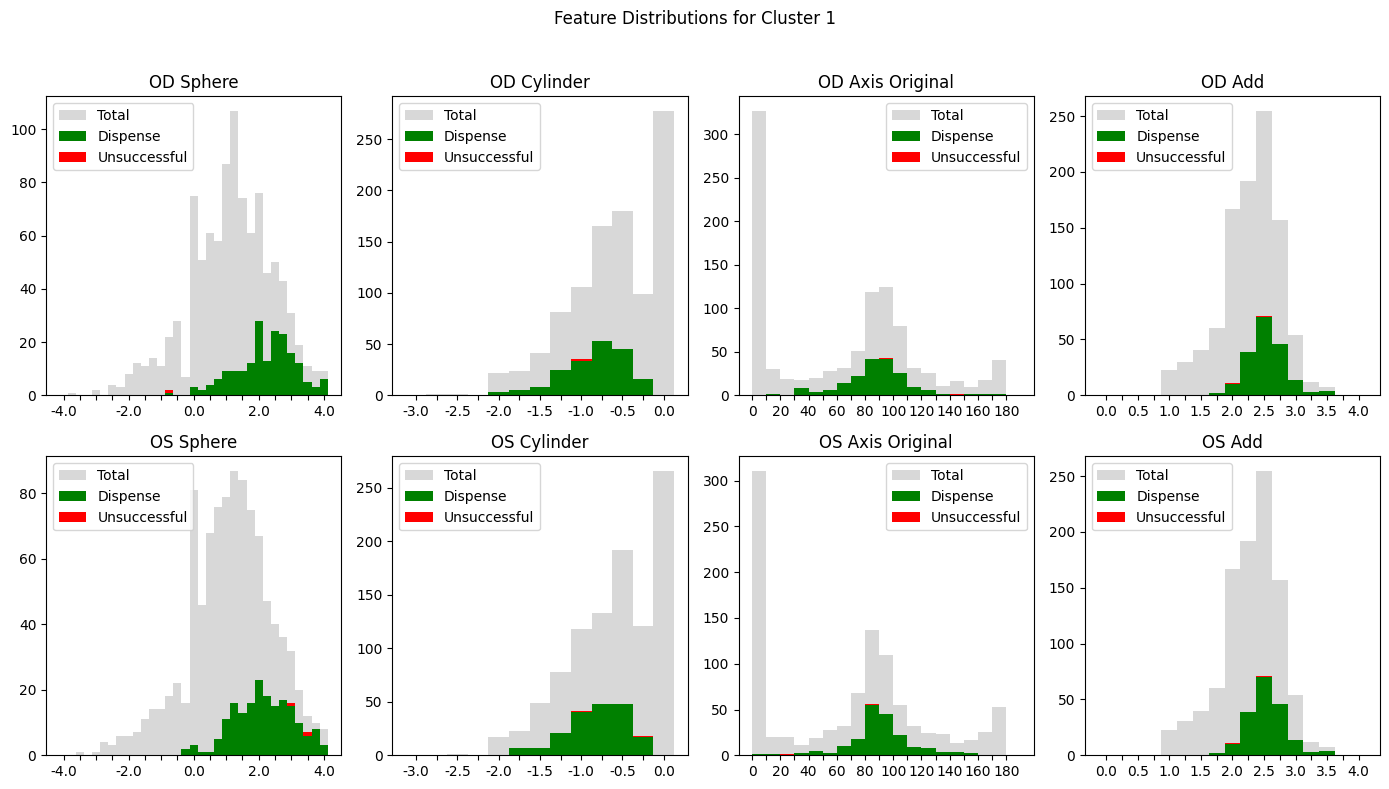

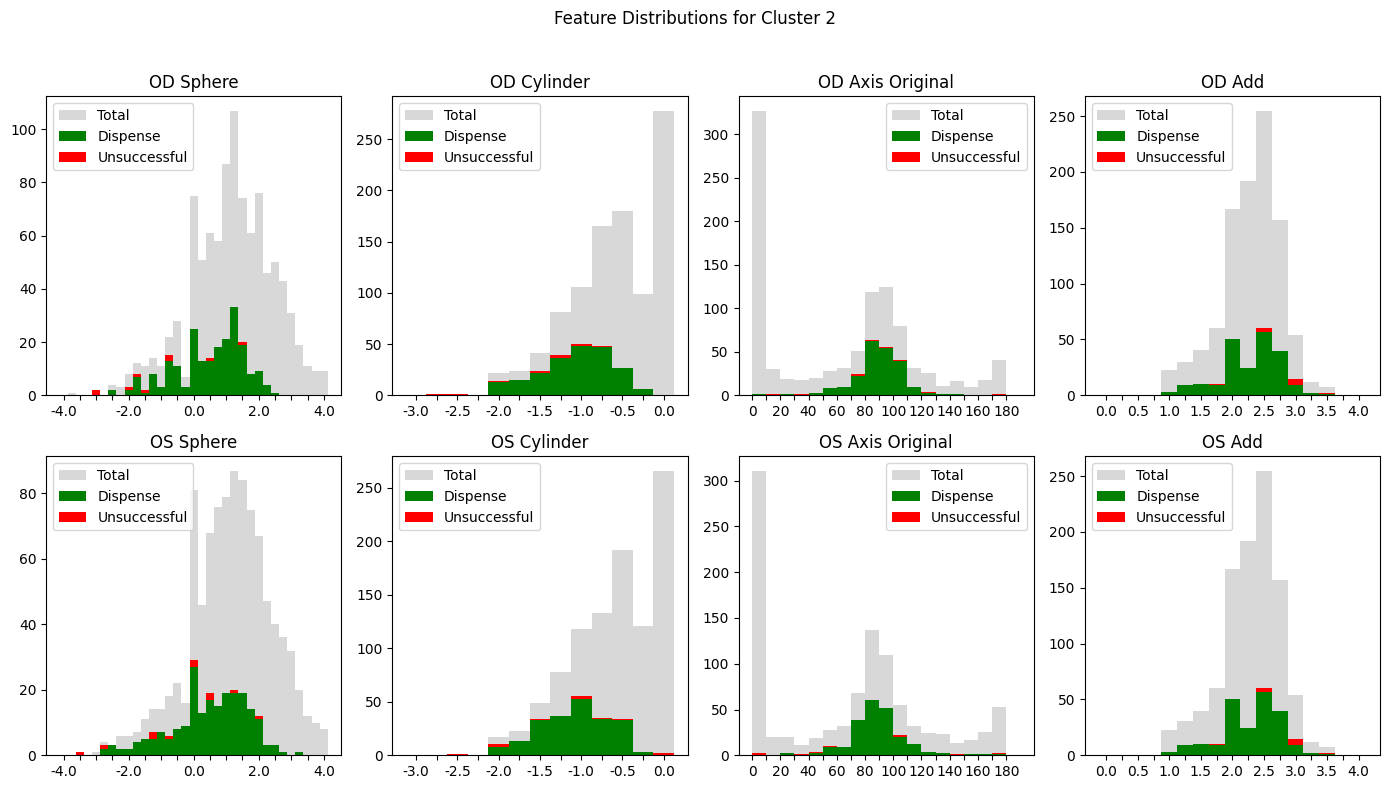

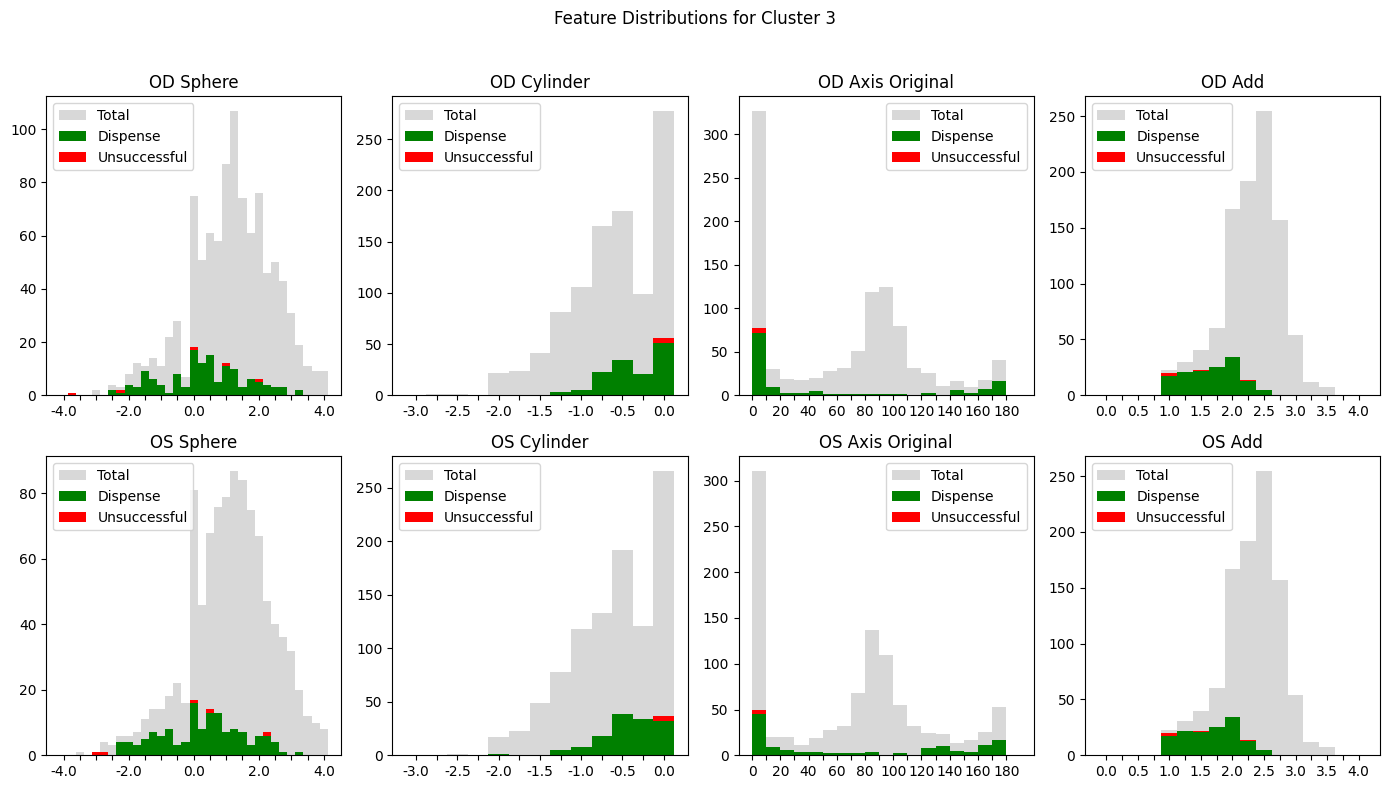

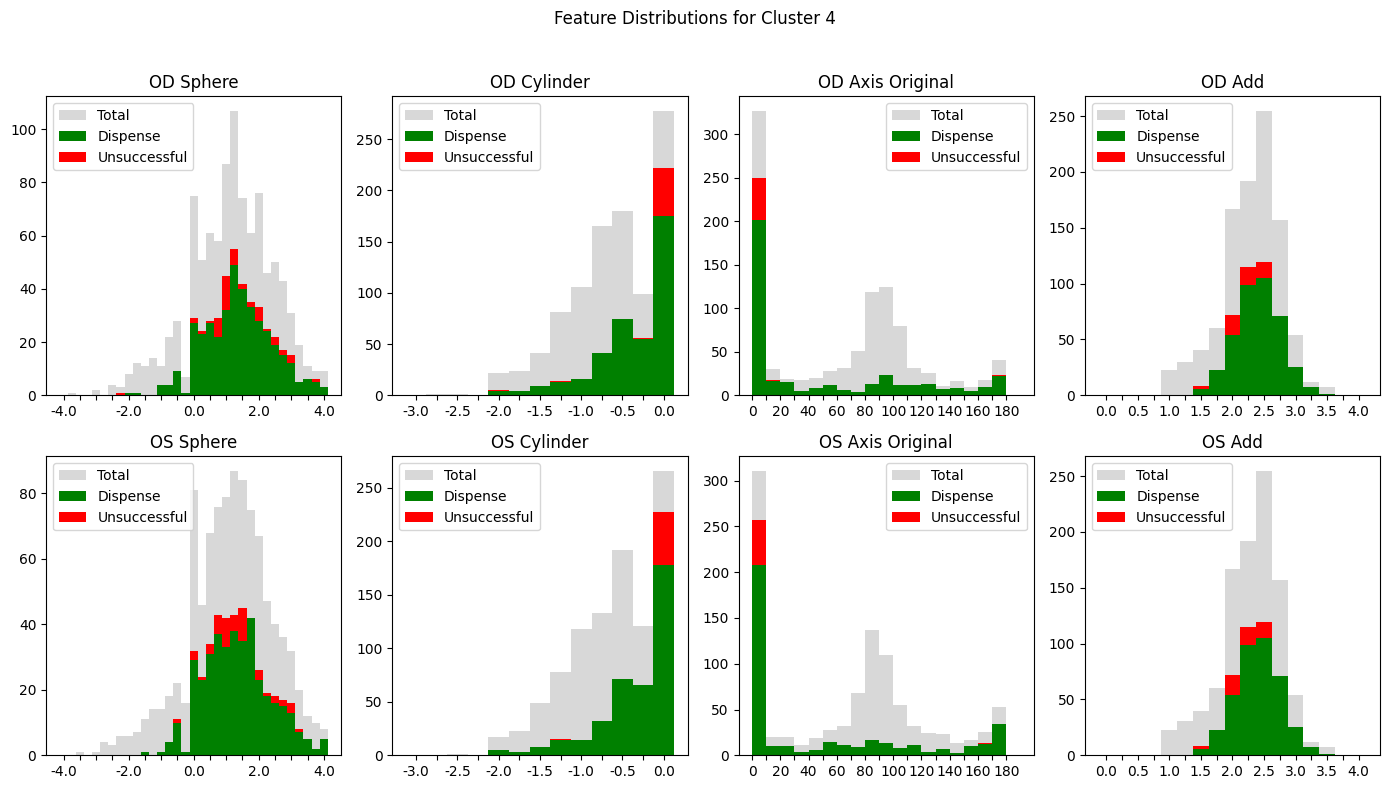

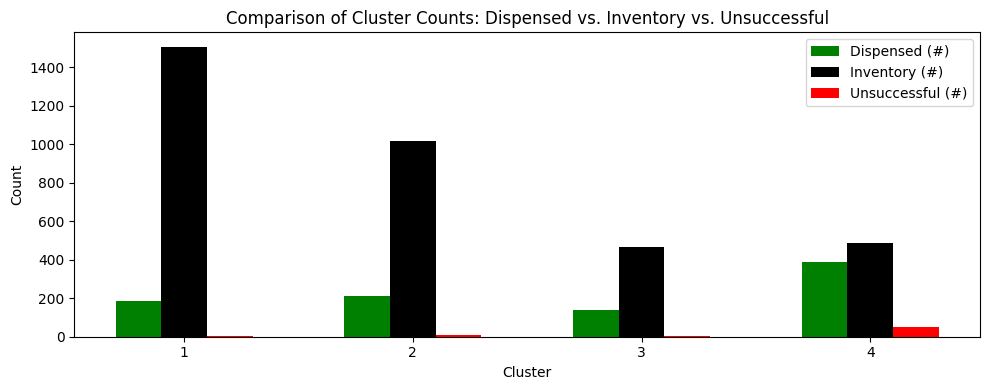

In [4]:
from analysis import launch
launch(multifocal=True, location='sm', cluster_count=4)